# A Script to Compute the Relative Entropy Rate between the Observations of Two Linear Systems 
(Second version)

In [6]:
import numpy as np
import scipy.linalg as la
import linalg_helpers as la_help
import control as ct
import compute_relative_entropy as com_rel
import matplotlib.pyplot as plt

In [ ]:
def generate_random_A(nx, W, type="gauss", cond_num_threshold=np.inf):
    cond_num = np.inf
    while cond_num >= cond_num_threshold:
        if type == "gauss":
            A = np.sqrt(0.33)*np.random.randn(nx, nx)
            max_eig = np.max(np.abs(la.eigvals(A)))
            A = 0.95*A / max_eig
        elif type == "upptri":
            A = np.diag(np.random.uniform(-1, 1, nx)) * 0.95
            A[np.triu_indices(nx, 1)] = np.random.uniform(-1, 1, (nx ** 2 + nx) // 2 - nx)

        Pi = ct.dlyap(A, W).astype(np.float64)
        cond_num = np.linalg.cond(Pi)
    print("cond_num of Pi: ", cond_num)

    return A.astype(np.float64), Pi

def generate_random_C(nx, ny, Pi, noise_sigma, E=1, zero_C=False):
    if zero_C:
        C = np.zeros((ny, nx))
    else:
        C = np.sqrt(0.333333333)*np.random.randn(ny, nx)
    V = (noise_sigma**2)*np.eye(ny).astype(np.float64) 

    obs_tr = np.trace(C @ Pi @ C.T + V)

    if obs_tr < 0:
        print("obs_tr negative:", obs_tr)
        print("evals of Pi", eval)
        print("evals greater than 0?", np.greater(eval, 0))
        print("all positive", np.all(np.greater(eval, 0)))
        print("eval of CPiCT:", la.eig(C @ Pi @ C.T))
        raise ValueError("Didn't catch negative evals")
    
    alpha = np.sqrt(E / obs_tr)

    C = alpha*C
    sigma_v = alpha*noise_sigma
    V = np.eye(ny) * (sigma_v ** 2)

    print("trace:", np.trace(C@Pi@C.T + V))
    return C.astype(np.float64), V.astype(np.float64)

In [13]:
nx = 2
ny = 2
noise_std = 1e-1

context = 8

# C = np.block([np.eye(ny), np.zeros((ny, nx-ny))]).astype(np.float64) # observable
W = (noise_std**2)*np.eye(nx).astype(np.float64)



In [ ]:
A,Pi = generate_random_A(nx, W)
Ap,Pi_p = generate_random_A(nx, W, type="gauss")

C, V = generate_random_C(nx, ny, Pi, noise_std)
Cp, Vp = generate_random_C(nx, ny, Pi_p, noise_std, zero_C=True)

# A = 0.95*np.eye(nx)
# Pi = ct.dlyap(A, W).astype(np.float64)
# Ap = 0.9*np.eye(nx)
# Pi_p = ct.dlyap(Ap, W).astype(np.float64)

cond_num of Pi:  4.0169892631732305
cond_num of Pi:  18.342593826814305
trace: 1.0000000000000002
trace: 0.9999999999999998


In [22]:
print("cond num of CPiC^T + V: ", np.linalg.cond(C @ Pi @ C.T + V))
print("cond num of CPi_pC^T + V: ", np.linalg.cond(Cp @ Pi_p @ Cp.T + Vp))
print("trace num of CPiC^T + V: ", np.trace(C @ Pi @ C.T + V))
print("trace num of CPi_pC^T + V: ", np.trace(Cp @ Pi_p @ Cp.T + Vp))


cond num of CPiC^T + V:  1.0
cond num of CPi_pC^T + V:  1.0
trace num of CPiC^T + V:  1.0000000000000002
trace num of CPi_pC^T + V:  0.9999999999999998


In [23]:
Kn, Kinvs, Finvs = com_rel.compute_cov_inv(A,C,V,Pi, context)
Kn_p, Kinvs_p, Finvs_p = com_rel.compute_cov_inv(Ap,Cp,Vp,Pi_p, context)

k: 0
cond(K_k): 1.0
k: 1
cond(K_k): 1.0
k: 2
cond(K_k): 1.0
k: 3
cond(K_k): 1.0
k: 4
cond(K_k): 1.0
k: 5
cond(K_k): 1.0
k: 6
cond(K_k): 1.0
k: 7
cond(K_k): 1.0
ran for context: 8
Matrix K_k @ K_k^inv:
    1.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     1.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     1.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     1.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000 
    0.0000     0.0000     0.0000     0.0000     1.0000     0.0000     0.0000     0.0000    

In [24]:
np.allclose(Kn, Kn_p)

True

# compute rel ent rate function

(using natural log)

In [18]:
def F_k(Kinv, ny):
    return Kinv[:ny, :ny]

def G_k(Kinv, ny):
    return Kinv[:ny, ny:]

In [19]:
rel_ent = []
print("len(finvs): ", len(Finvs))

for k in range(context):

    Gk = G_k(Kinvs[k], ny)
    Gpk = G_k(Kinvs_p[k], ny)
    Fk = F_k(Kinvs[k], ny)
    Fpk = F_k(Kinvs_p[k], ny)
    if k ==0:
        K0 = com_rel.K_k(Kn,ny,0)
        K0_p = com_rel.K_k(Kn_p,ny,0)
        
        rel_ent.append(0.5*(np.log(la.det(K0_p)) - np.log(la.det(K0)) + np.trace(Kinvs_p[k]@K0 - np.eye(ny)))) #from Polyanskiy and Wu Ex. 2.2 (non conditional relative entropy between two multivariate gaussians)
    else:
        print("k:", k)
        print("first term:", np.log(la.det(Finvs[k])) - np.log(la.det(Finvs_p[k])))
        print("second term:", ny - np.trace(Finvs[k]@Fpk) - np.trace((Gk.T@Finvs[k]@Fpk@Finvs[k]@Gk - 2*Gpk.T@Finvs[k]@Gk + Gpk.T@Finvs_p[k]@Gpk)@Kinvs[k-1] ) )
        rel_ent.append(rel_ent[k-1] - 0.5*(ny + np.log(la.det(Finvs[k])) - np.log(la.det(Finvs_p[k])) - np.trace(Finvs[k]@Fpk) - np.trace((Gk.T@Finvs[k]@Fpk@Finvs[k]@Gk - 2*Gpk.T@Finvs[k]@Gk + Gpk.T@Finvs_p[k]@Gpk)@Kinvs[k-1] ) )    )

print("rel_ent: ", rel_ent)
rel_ent_rates = [x / y for x, y in zip(rel_ent, range(1, len(rel_ent) + 1))]
rel_ent_rates = np.array(rel_ent_rates)

len(finvs):  8
k: 1
first term: 0.0
second term: 0.0
k: 2
first term: 0.0
second term: 0.0
k: 3
first term: 0.0
second term: 0.0
k: 4
first term: 0.0
second term: 0.0
k: 5
first term: 0.0
second term: 0.0
k: 6
first term: 0.0
second term: 0.0
k: 7
first term: 0.0
second term: 0.0
rel_ent:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


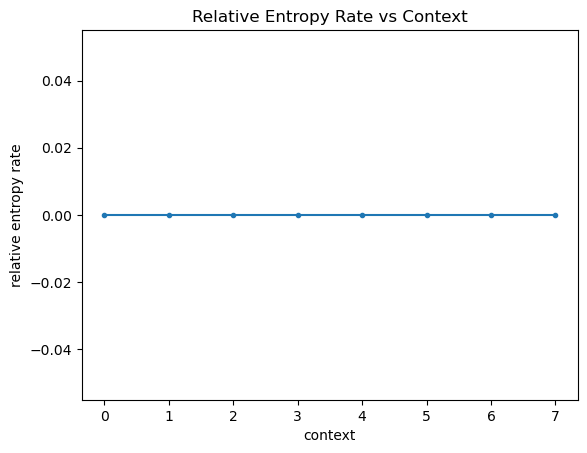

In [20]:
#plot the relative entropy rate vs the context
logscale=False
if logscale:
    intercept = 0.032
    plt.xscale("log")
    plt.yscale("log")
else:
    intercept = 0.0

plt.plot(range(context), rel_ent_rates-intercept, marker=".")
plt.xlabel("context")
plt.ylabel("relative entropy rate")
plt.title("Relative Entropy Rate vs Context")

# plt.ylim([-0.25, 20])
plt.show()

Compute the powers of $A$ and the first row of $K_N$

In [60]:
A_powers = la_help.compute_powers(A, context)

values = C@A_powers@Pi@C.T
for i in range(context):
    la_help.print_matrix(values[i], f"C A^{i} Π C^T")

# values = la_help.lower_threshold_matrix(values, 1e-5)
# for i in range(context):
#     la_help.print_matrix(values[i], f"C A^{i} Π C^T thresholded")

AttributeError: module 'linalg_helpers' has no attribute 'compute_powers'

Compute $K_N$

In [51]:
Kn = la_help.block_toeplitz(values) + la_help.create_repeated_block_diagonal(V, context)
print("shape of Kn: ", Kn.shape)

shape of Kn:  (50, 50)




Let $K_k^{-1} = \begin{bmatrix}
    F_k & G_k\\
    G_k^T & H_k
\end{bmatrix}$.

### Computing the Block Inverse Matrices
Let us give the off-diagonal blocks of $K_k$ the name $K_{off}$. This means, $K_k \triangleq \begin{bmatrix}
    K_{0} & K_{off}\\
    K_{off}^T & K_{k-1}
\end{bmatrix}$.
\begin{align}
    &K_k K_k^{-1} = I\\ 
    &\Rightarrow K_0 F_k + K_{off} G_k^T = I; \,\, K_{off}^T G_k + K_{k-1} H_k = I; \,\, K_0 G_k + K_{off} H_k = \mathbf{0}; \,\, \text{and } K_{off}^T F_k + K_{k-1} G_k^T = \mathbf{0}\\
    &\Rightarrow F_k = \left(K_0 - K_{off}K_{k-1}^{-1}K_{off}^T\right)^{-1}; \\ 
    &G_k = -F_k K_{off}K_{k-1}^{-1};\\
    &\text{and } H_k = K_{k-1}^{-1}\left(I - K_{off}^T G_k\right).
\end{align}

#### Remark
$F_k^{-1} = K_0 - K_{off}K_{k-1}^{-1}K_{off}^T$ requires no extra inverse because $K_{k-1}^{-1}$ is computed on the previous iteration. Furthermore $F_k^{-1} \in \R{m\times m}$ always, so computing $F_k$ only requires the inversion of a small matrix compared to the dimension of $K_k$.

Compute $F_k^{-1}$, $G_k^{-1}$, and $K_k^{-1}$ for all $k$.

In [30]:
def K_k(Kn, k):
    # The k-th Covariance matrix for the observation process
    return Kn[-ny*(k+1):, -ny*(k+1):]

In [52]:
print("eigvals of K0:", abs(la.eigvals(C@Pi@C.T + V)))
print("eigvals of Pi:", abs(la.eigvals(Pi)))

eigvals of K0: [1.7288974  0.28881186 0.43538825 0.8025     0.76926803]
eigvals of Pi: [1.34967128 0.41611701 0.26497633 0.16979608 0.15427598 0.12513894
 0.10000592 0.1047625  0.11146293 0.1092621 ]


In [55]:
Kinvs = []
Finvs = []
for k in range(context):
    if k == 0:
        Kinvs.append(la.inv(K_k(Kn, 0)))
    else:
        # la_help.print_matrix(K_k(Kn,k), f"K_{k}")
        K0 = K_k(Kn, 0)
        Koff = K_k(Kn, k)[:ny, ny:]

        Finv = (K0 - Koff@Kinvs[k-1]@Koff.T)
        Finvs.append(Finv)

        Fk = la.inv(Finv)
        if not np.allclose(Fk@Finv, np.eye(ny), atol=1e-10):
            la_help.print_matrix(Fk@Finv, "Fk @ Finv")
            raise ValueError("Fk is not the inverse of Finv")
        
        Gk = -Fk@Koff@Kinvs[k-1]
        Hk = Kinvs[k-1]@(np.eye(ny*k) - Koff.T@Gk)
        Kinvs.append(np.block([[Fk, Gk], [Gk.T, Hk]]))

        if not np.allclose(K_k(Kn, k)@Kinvs[k], np.eye(ny*(k+1)), atol=1e-5):
            print("k:", k)
            print("eigvals of Kinvs[k]:", np.sort(np.real(la.eigvals(Kinvs[k])))[::-1])
            print("eigvals of K_k", np.sort(np.real(la.eigvals(K_k(Kn, k))))[::1])
            la_help.print_matrix(Koff, "Koff")
            la_help.print_matrix(Fk, "Fk")
            la_help.print_matrix(Finv, "Finv")
            la_help.print_matrix(Gk, "Gk")
            la_help.print_matrix(K_k(Kn, k)@Kinvs[k], "K_k @ K_k^inv")
            context = k
            raise ValueError("K_k^inv is not the inverse of K_K")
    
print("ran for context:", context)
la_help.print_matrix(K_k(Kn, k)@Kinvs[k], "K_k @ K_k^inv")

ran for context: 10
Matrix K_k @ K_k^inv:
    1.0000    -0.0000     0.0000    -0.0000     0.0000    -0.0000    -0.0000     0.0000     0.0000     0.0000     0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000     0.0000     0.0000    -0.0000    -0.0000    -0.0000    -0.0000    -0.0000     0.0000    -0.0000    -0.0000    -0.0000    -0.0000     0.0000     0.0000    -0.0000     0.0000     0.0000    -0.0000    -0.0000     0.0000     0.0000    -0.0000     0.0000    -0.0000    -0.0000     0.0000     0.0000    -0.0000     0.0000     0.0000    -0.0000    -0.0000    -0.0000     0.0000 
    0.0000     1.0000    -0.0000     0.0000    -0.0000     0.0000    -0.0000     0.0000     0.0000    -0.0000    -0.0000    -0.0000     0.0000     0.0000     0.0000     0.0000    -0.0000     0.0000     0.0000     0.0000     0.0000    -0.0000    -0.0000    -0.0000     0.0000     0.0000     0.0000     0.0000    -0.0000    -0.0000     0.0000    -0.0000    -0.0000     0.0000     0.0000    -0.0000     0.0000 